In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from itertools import product
import glob
import re
import warnings
from random import sample
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv('data/X_without_lags_and_target_encoding.csv')
y = pd.read_csv('data/y_without_lags_and_target_encoding.csv').item_cnt
X_test = pd.read_csv('data/test_without_lags_and_target_encoding.csv', index_col='ID')

In [3]:
types = {
    'date_block_num': 'int8',
    'shop_id': 'int8',
    'item_id': 'int16',
    'item_category_id': 'int8',
    'super_category': 'int8',
    'category': 'int8',
    'city': 'int8',
    'shop_type': 'int8',
    'shop_name': 'int8'
}
X = X.astype(types)
X_test = X_test.astype(types)

In [4]:
X_train = X[X.date_block_num < 33]
y_train = y[X.date_block_num < 33]

X_val = X[X.date_block_num == 33]
y_val = y[X.date_block_num == 33]

# Some functions

In [5]:
def RMSE(series_true, series_predicted):
    return sum((series_true - series_predicted)**2 / len(series_true))**0.5

In [6]:
def EMA(ser, alpha):
    y_1 = ser[0]
    for y in ser:
        y_1 = (1 - alpha) * y_1 + alpha * y
    return y_1

In [7]:
def submit(y_predicted):
    my_submissions_paths = glob.glob('./data/my_submission_*.csv')
    nums = [int(re.findall(r'\d+', filepath)[0]) for filepath in my_submissions_paths]
    n = max(nums) + 1
    submission = pd.read_csv('data/sample_submission.csv')
    submission.item_cnt_month = y_predicted
    submission.to_csv(f'data/my_submission_{n}.csv', index=None)
    return f'data/my_submission_{n}.csv'

# Training models

### class MyAbstractModel

The interface of classes.  
The *fit* method extract all time series for each (shop_id, item_id) element.  
The *predict_shop_item* method returns the prediction for one (shop_id, item_id) element.  
The *predict* method returns the array of clipped predictions for each of the (shop_id, item_id) element.  

In [8]:
class MyAbstractModel:
    def __init__(self, model_init, *model_args, **model_kwargs):
        self.model_init = model_init
        self.model_args = model_args
        self.model_kwargs = model_kwargs
        
    def fit(self, X_train, y_train):
        X = X_train.copy()
        X['target'] = y_train
        self.all_series = X.groupby(
            ['shop_id', 'item_id', 'date_block_num']).target.sum().unstack(fill_value=0).clip(0, 20)
        
    def predict_shop_item(self, shop_id, item_id):
        pass

    def predict(self, X):
        return np.clip(
            [self.predict_shop_item(shop_id, item_id) for shop_id, item_id in X[['shop_id', 'item_id']].values],
            0, 20)

### class AbstractModelEMADefault

It expands the previous interface with the *predict_small_history* method which is used when the time series has a lot of zeros. The meaning of "a lot of zeros" is defined for each subclass (e.g. the number of zeros is greater than 20).

In [9]:
class AbstractModelEMADefault(MyAbstractModel):
    def __init__(self, model_init, ema_koeff=0.4, *model_args, **model_kwargs):
        MyAbstractModel.__init__(self, model_init, *model_args, **model_kwargs)
        self.ema_koeff = ema_koeff

    def predict_small_history(self, shop_id, item_id):
        ser = list(self.all_series.loc[(shop_id, item_id)])
        return EMA(ser, self.ema_koeff)       

## class LinRegModel

This class uses linear regression for the predicting. For each time series new dataframe that contains lag features is built. The parameter *window* defined the number of lag features. And for this dataframe the linear regression is fitted.

In [10]:
class LinRegModel(AbstractModelEMADefault):
    def __init__(self, window=12, ema_koeff=0.4, *model_args, **model_kwargs):
        
        model_init = ElasticNet
        AbstractModelEMADefault.__init__(self, model_init, ema_koeff, *model_args, **model_kwargs)
        self.window = window
    
    def predict_shop_item(self, shop_id, item_id):
        
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 0
        if all(np.array(ser)[:-self.window] == 0):
            return self.predict_small_history(shop_id, item_id)
        
        window_df = pd.DataFrame([ser[k : k + self.window] for k in range(len(ser) - self.window + 1)])
        X, y = window_df.drop(columns=[self.window - 1]), window_df[self.window - 1]
        
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        model = self.model_init(*self.model_args, **self.model_kwargs)
        model.fit(X, y)
        test_X = scaler.transform(pd.DataFrame([ser[-self.window + 1:]]))
        return model.predict(test_X)[0]

In [11]:
lin_reg_model = LinRegModel()
lin_reg_model.fit(X_train, y_train)
lin_reg_predicted = lin_reg_model.predict(X_val)
RMSE(y_val, lin_reg_predicted)

1.0445877034628965

## class PartEMAAndConstModel

This class uses the following idea: if there are a lot of zeros at the beginning of time series, then EMA is used. If there are some zeros at the end, then the predicted value is 0. Otherwise some model is used. I chose the lightGBM because it's a powerful and relatively fast model.

In [12]:
class PartEMAAndConstModel(AbstractModelEMADefault):
    
    def __init__(self, model_init, ema_threshold, const_threshold, window=12, ema_koeff=0.4, *model_args, **model_kwargs):

        AbstractModelEMADefault.__init__(self, model_init, ema_koeff, *model_args, **model_kwargs)
        self.window = window
        self.ema_threshold = ema_threshold
        self.const_threshold = const_threshold
    
    def predict_shop_item(self, shop_id, item_id):
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 0
        
        if all(np.array(ser)[self.const_threshold:] == 0):
            return 0
        
        if all(np.array(ser)[:self.ema_threshold] == 0):
            return self.predict_small_history(shop_id, item_id)

        window_df = pd.DataFrame([ser[k : k + self.window] for k in range(len(ser) - self.window + 1)])
        X, y = window_df.drop(columns=[self.window - 1]), window_df[self.window - 1]
        
        model = self.model_init(*self.model_args, **self.model_kwargs)
        model.fit(X, y)
        return model.predict(pd.DataFrame([ser[-self.window + 1:]]))[0]        

The score for some parameters:

In [13]:
part_ema_and_const_model = PartEMAAndConstModel(LGBMRegressor, 2, -4, max_depth=2, n_estimators=100)
part_ema_and_const_model.fit(X_train, y_train)
part_ema_and_const_predicted = part_ema_and_const_model.predict(X_val)
RMSE(y_val, part_ema_and_const_predicted)

1.0120234520105569

These parameters mean that the predicted value equals 0, if the last 4 elements equal 0, EMA of the series if the first 2 elements of time series equal 0. Otherwise it is calculated using lightGBM. Let's take a look at scores for different parameters.

In [14]:
tune_params = sample(list(product(range(1, 4), range(-10, -1), range(12, 24))), 50)
tune_params

[(3, -5, 19),
 (2, -10, 15),
 (2, -7, 19),
 (1, -7, 21),
 (3, -7, 18),
 (1, -9, 22),
 (1, -9, 17),
 (2, -7, 23),
 (1, -9, 12),
 (2, -5, 22),
 (2, -9, 16),
 (3, -6, 19),
 (3, -3, 20),
 (3, -5, 23),
 (2, -2, 18),
 (3, -2, 19),
 (2, -6, 15),
 (1, -9, 18),
 (1, -8, 23),
 (3, -4, 23),
 (1, -2, 18),
 (1, -4, 13),
 (1, -2, 17),
 (2, -9, 17),
 (2, -3, 20),
 (1, -2, 16),
 (2, -8, 14),
 (1, -2, 14),
 (1, -3, 17),
 (3, -4, 19),
 (1, -8, 22),
 (2, -7, 17),
 (2, -6, 20),
 (3, -5, 14),
 (1, -4, 16),
 (1, -5, 14),
 (1, -10, 16),
 (3, -7, 15),
 (1, -6, 14),
 (1, -7, 23),
 (2, -8, 17),
 (3, -7, 17),
 (3, -5, 20),
 (1, -6, 21),
 (1, -4, 20),
 (2, -3, 12),
 (1, -2, 19),
 (3, -4, 18),
 (2, -7, 18),
 (2, -9, 12)]

In [15]:
train_scores = {}
val_scores = {}

for max_depth, const_threshold, ema_threshold in tune_params:
    part_ema_and_const_model = PartEMAAndConstModel(LGBMRegressor,
                                                      ema_threshold, const_threshold,
                                                      max_depth=max_depth, n_estimators=100)
    part_ema_and_const_model.fit(X_train, y_train)
    
    part_ema_and_const_predicted_val = part_ema_and_const_model.predict(X_val)
    val_scores[(max_depth, const_threshold, ema_threshold)] = RMSE(y_val, part_ema_and_const_predicted_val)
    
    print('max_depth:', max_depth)
    print('const_threshold:', const_threshold)
    print('ema_treshold:', ema_threshold)
    print('val score:', val_scores[(max_depth, const_threshold, ema_threshold)])
    print('------------------------------------------')

max_depth: 3
const_threshold: -5
ema_treshold: 19
val score: 1.044985608192232
------------------------------------------
max_depth: 2
const_threshold: -10
ema_treshold: 15
val score: 1.0472865095157557
------------------------------------------
max_depth: 2
const_threshold: -7
ema_treshold: 19
val score: 1.0483762939258048
------------------------------------------
max_depth: 1
const_threshold: -7
ema_treshold: 21
val score: 1.0465864102535547
------------------------------------------
max_depth: 3
const_threshold: -7
ema_treshold: 18
val score: 1.04662983305087
------------------------------------------
max_depth: 1
const_threshold: -9
ema_treshold: 22
val score: 1.0489616458704587
------------------------------------------
max_depth: 1
const_threshold: -9
ema_treshold: 17
val score: 1.0487146909131089
------------------------------------------
max_depth: 2
const_threshold: -7
ema_treshold: 23
val score: 1.0478320350970232
------------------------------------------
max_depth: 1
const

In [18]:
val_scores_df = pd.DataFrame(val_scores, index=[1]).T.reset_index()\
    .rename(columns={
    'level_0': 'max_depth',
    'level_1': 'const_threshold',
    'level_2': 'ema_threshold',
    1: 'val_score'
})

val_scores_df[val_scores_df.val_score == val_scores_df.val_score.min()]

,max_depth,const_threshold,ema_threshold,val_score
27,1,-2,14,1.030021


So the best model with parametres among *tune_params* has a score 1.030021. It is higher than the score of model with params ema_threshold equals 2 and const_threshold equals -4. It might mean that the ema model is better for the most of series.

## EMA model

In [27]:
class EMAModel(MyAbstractModel):
    
    def __init__(self, ema_koeff):

        MyAbstractModel.__init__(self, None)
        self.ema_koeff = ema_koeff
        
    def predict_shop_item(self, shop_id, item_id):
        try:
            ser = list(self.all_series.loc[(shop_id, item_id)])
        except KeyError as e:
            return 0
        
        return EMA(ser, self.ema_koeff)

In [32]:
ema_scores = {}
for ema_koeff in np.linspace(0.1, 0.9, 9):
    ema_model = EMAModel(ema_koeff=ema_koeff)
    ema_model.fit(X_train, y_train)
    ema_predicted = ema_model.predict(X_val)
    ema_scores[ema_koeff] = RMSE(y_val, ema_predicted)

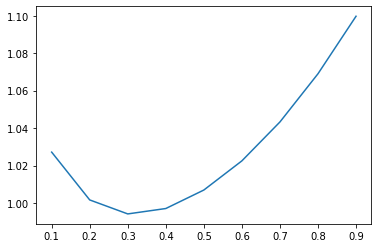

In [33]:
plt.plot(ema_scores.keys(), ema_scores.values())
plt.show()

The best score:

In [39]:
min(ema_scores.values())

0.9941518427652923

The ema_koeff equals 0.3. So the ema model is better than partly const and ema model and the model with linear regression.

# final predictions

In [34]:
final_model = EMAModel(ema_koeff=0.3)

In [35]:
final_model.fit(X, y)

In [36]:
final_prediction = final_model.predict(X_test)

In [37]:
submit(final_prediction)

'data/my_submission_32.csv'

The score is 1.05381. It is greater than the score of the model fitted on the dataset with lag features and some categories. It is obviously because EMA is a simple algorithm and the dataset doesn't contain information about items, their categories and shops.